In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import IPython
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20,8)

In [3]:
dat = np.fromfile("/home/faux/a.sr312500.cf32", dtype=np.float32).astype(np.float32).view(np.complex64)
SR = 225000

In [4]:
def spec(dat, sr=SR):
    plt.specgram(dat, NFFT=32, noverlap=16, Fs=sr)

def freq(dat):
    plt.psd(dat, NFFT=1024, Fs=SR)

def tone(freq, samples):
    return np.exp(-2j*np.pi*-freq/SR*np.arange(samples))

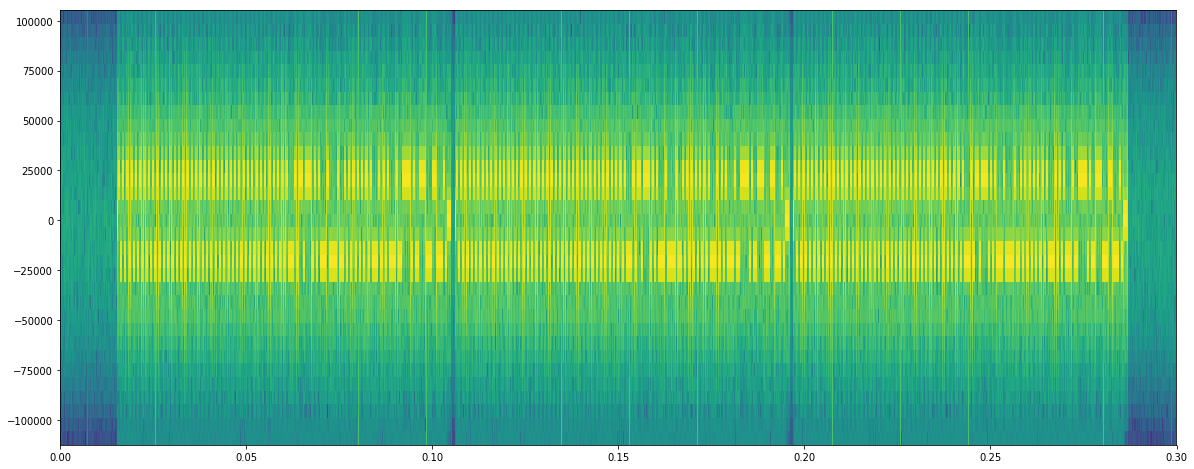

In [5]:
cut = dat[int(0.12*SR):int(0.42*SR)];
spec(cut)

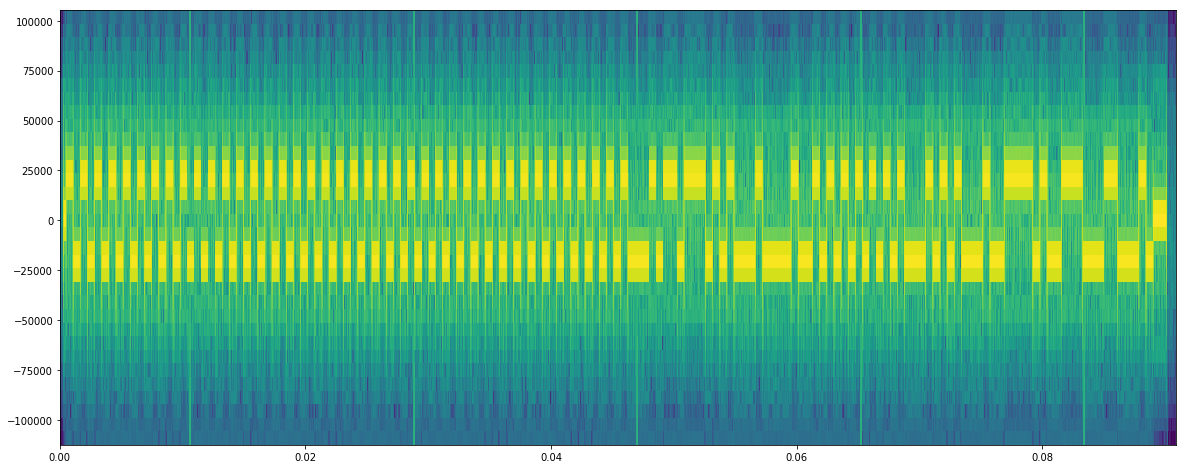

In [6]:
pre = cut[int(0.015*SR):int(0.106*SR)]
spec(pre)

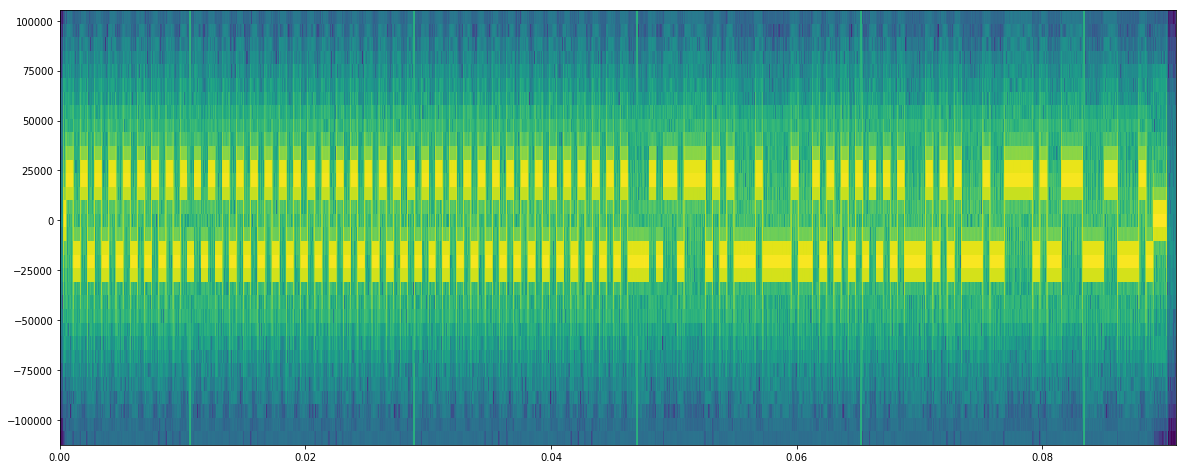

In [8]:
spec(pre*np.exp(-2j*np.pi*7/SR*np.arange(len(pre))))

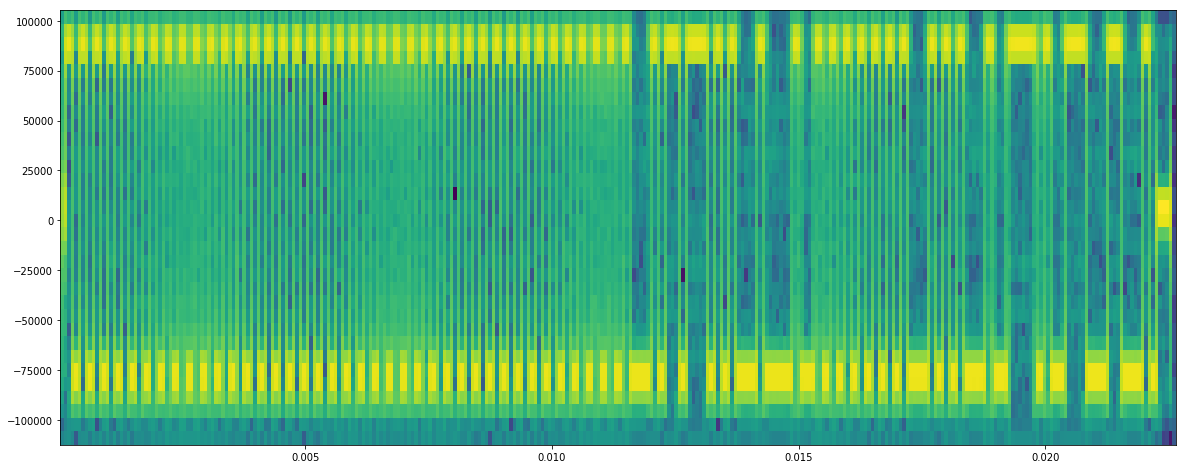

In [9]:
n_taps = 32
f_bw = 25000
lpf = signal.remez(n_taps, [0, f_bw, f_bw+(SR/2-f_bw)/4, SR/2], [1,0], Hz=SR)
dec = signal.decimate(pre, 4, zero_phase=True)
spec(dec)

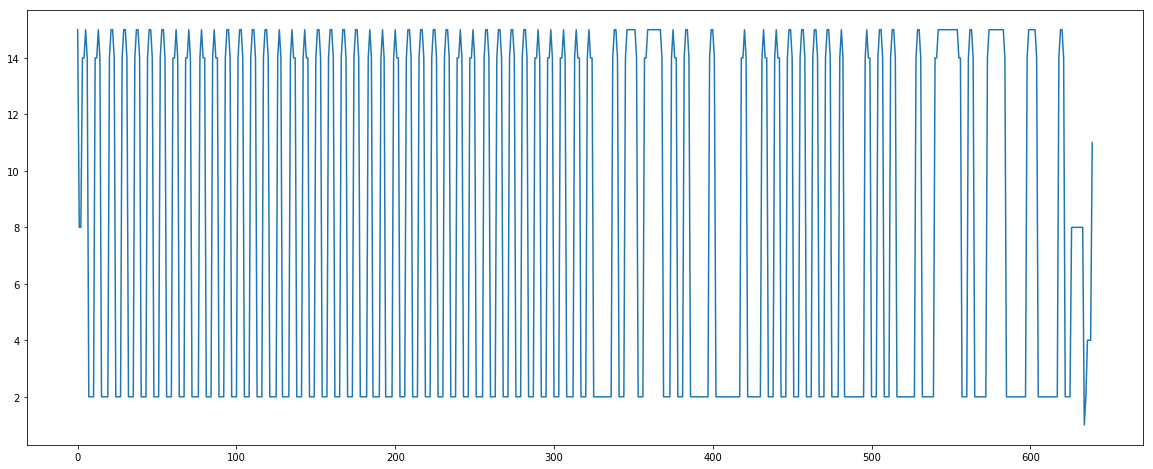

In [10]:
import scipy.fftpack as ffts
import operator

from itertools import islice

def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n // 2):
        yield l[i:i + n]

def best(slic):
    mags = [abs(x*x) for x in ffts.ifft(slic)]
    mags = mags[len(slic)//2:] + mags[:len(slic)//2]
    return max(enumerate(mags), key=operator.itemgetter(1))[0]

_ = plt.plot([16-best(x) for x in chunks(dec, 16)])

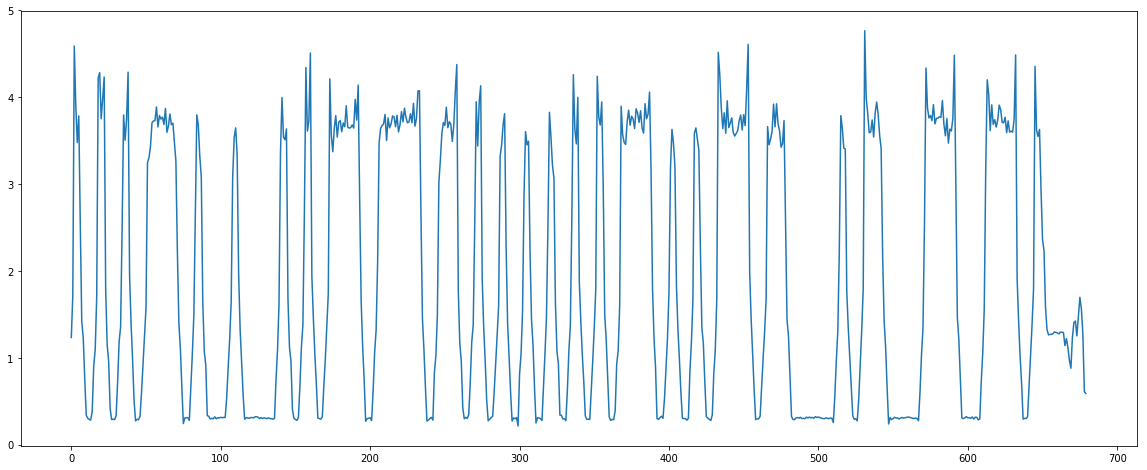

In [11]:
import scipy.fftpack as ffts
import operator

from itertools import islice

def chunks(l, n):
    for i in range(0, len(l), n // 4):
        yield l[i:i + n]

def best(slic):
    mags = (abs(x) for x in ffts.ifft(slic))
    low = sum(islice(mags, len(slic) // 2))
    hi = sum(mags)
    return low / hi

dat = [best(x) for x in chunks(dec, 16)]
_ = plt.plot(dat[600:])

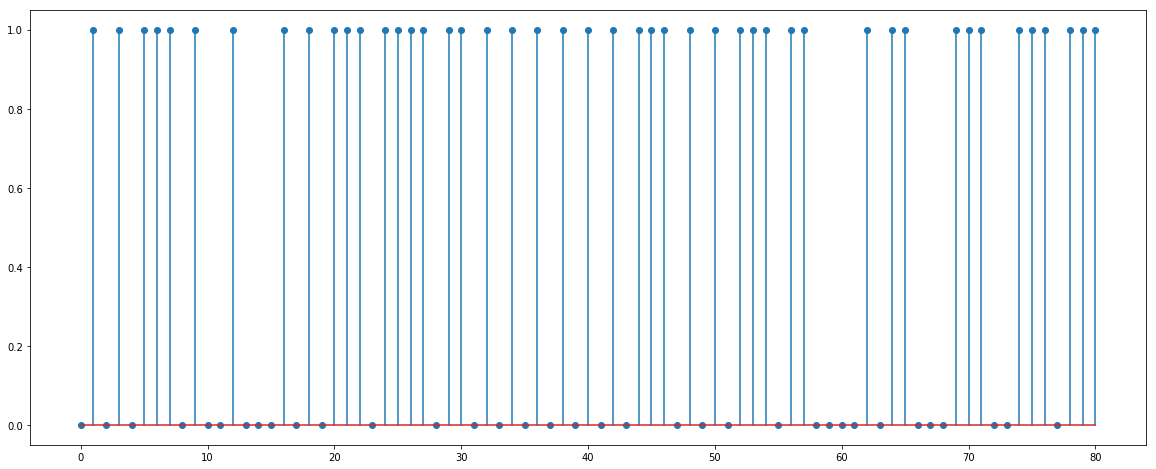

In [12]:
def dec(val):
    cur = False
    lo = 0
    hi = 0
    un = 0
    for item in val:
        if item < 1:
            if cur:
                for i in range(round((hi+un)/8)):
                    yield cur
                #yield (lo, hi, un)
                lo = 0; hi = 0; un = 0
                cur = False
            else:
                lo += 1
        elif item > 3:
            if not cur:
                for i in range(round((lo+un)/8)):
                    yield cur
                #yield (lo, hi, un)
                lo = 0; hi = 0; un = 0
                cur = True
            else:
                hi += 1
        else:
            un += 1

man = list(dec(dat))
_ = plt.stem(man[75:])

In [13]:
def slide(x):
    for i in range(0, len(x), 8):
        yield x[i:i+8]

bits = ''.join('0' if x else '1' for x in man[80:])
[list(int(x, 2) for x in slide(bits[s:])) for s in range(12)]

[[22, 234, 33, 42, 170, 42, 39, 167, 24, 8],
 [45, 212, 66, 85, 84, 84, 79, 78, 49, 0],
 [91, 168, 132, 170, 168, 168, 158, 156, 98, 0],
 [183, 81, 9, 85, 81, 81, 61, 56, 196, 0],
 [110, 162, 18, 170, 162, 162, 122, 113, 136],
 [221, 68, 37, 85, 69, 68, 244, 227, 8],
 [186, 136, 74, 170, 138, 137, 233, 198, 8],
 [117, 16, 149, 85, 21, 19, 211, 140, 8],
 [234, 33, 42, 170, 42, 39, 167, 24, 8],
 [212, 66, 85, 84, 84, 79, 78, 49, 0],
 [168, 132, 170, 168, 168, 158, 156, 98, 0],
 [81, 9, 85, 81, 81, 61, 56, 196, 0]]